# imports

In [ ]:
pip install rasterio

In [ ]:
pip install mercantile

In [ ]:
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show
from rasterio.io import MemoryFile
import shapely
from shapely.geometry import box, shape
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import tempfile
from PIL import Image
import mercantile
from tqdm import tqdm

# Create tiff out of image.png

input: image.png, (lat, lon), spacial resilution, height, width

output: image.tiff, EPSG:4326

In [ ]:
def read_image_by_index(img_index):
  metadata = pd.read_csv('/content/drive/MyDrive/GeoAI/Sudan_school_data.csv')

  img_name = str(metadata['MOEcode'].values[img_index])+'.png'
  img_lon = metadata['lon'].values[img_index]
  img_lat = metadata['lat'].values[img_index]

  return img_name, img_lon, img_lat


In [ ]:
def read_image_by_id(img_id):
  metadata = pd.read_csv('/content/drive/MyDrive/GeoAI/Sudan_school_data.csv')

  metadata = metadata[['lat', 'lon','MOEcode']]
  metadata = metadata[metadata['MOEcode'] == img_id]

  img_name = str(img_id)+'.png'
  img_lon = metadata['lon'].values[0]
  img_lat = metadata['lat'].values[0]
  return img_name, img_lon, img_lat

In [ ]:
def georeference_image(image_width, image_height, spatial_resolution, img_lon, img_lat):
  # Calculate conversion factor from meters to degrees at the center latitude
  meters_per_degree_lat = 111132.92 - 559.82 * math.cos(2 * math.radians(img_lat)) + 1.175 * math.cos(4 * math.radians(img_lat)) - 0.0023 * math.cos(6 * math.radians(img_lat))
  meters_per_degree_lon = 111412.84 * math.cos(math.radians(img_lat)) - 93.5 * math.cos(3 * math.radians(img_lat)) + 0.118 * math.cos(5 * math.radians(img_lat))

  # Calculate bounding box coordinates in EPSG:4326
  x_min = img_lon - (image_width * spatial_resolution / (2 * meters_per_degree_lon))
  x_max = img_lon + (image_width * spatial_resolution / (2 * meters_per_degree_lon))
  y_min = img_lat - (image_height * spatial_resolution / (2 * meters_per_degree_lat))
  y_max = img_lat + (image_height * spatial_resolution / (2 * meters_per_degree_lat))

  # Calculate spatial resolution in degrees
  spatial_resolution_degrees = spatial_resolution / meters_per_degree_lat

  return x_min, x_max, y_min, y_max, spatial_resolution_degrees



def create_tiff(img_filename, input_folder, img_width, img_height, spacial_resolution, img_lon, img_lat):
    x_min, x_max, y_min, y_max, spatial_resolution_degrees = georeference_image(img_width, img_height, spacial_resolution, img_lon, img_lat)

    # Step 2: Load PNG image
    image = Image.open(os.path.join(input_folder, img_filename))

    # Step 3: Convert image to numpy array
    image_array = np.array(image)

    # Calculate transformation matrix
    transform = from_origin(x_min, y_max, spatial_resolution_degrees, spatial_resolution_degrees)

    # Create in-memory GeoTIFF file
    with MemoryFile() as memfile:
        with memfile.open(driver='GTiff', width=img_width, height=img_height, count=4, dtype=image_array.dtype, crs='EPSG:4326', transform=transform) as dst:
            # Write each band to GeoTIFF
            for band in range(4):
                dst.write(image_array[:, :, band], band + 1)

        # Read the content of the in-memory file
        tiff_content = memfile.read()

    return tiff_content

def save_tiff(img_filename, input_folder,  img_width, img_height, spacial_resolution, img_lon, img_lat, output_folder):
  x_min, x_max, y_min, y_max, spatial_resolution_degrees = georeference_image(img_width, img_height, spacial_resolution, img_lon, img_lat)

  # Step 2: Load PNG image
  image = Image.open(os.path.join(input_folder, img_filename))

  # Step 3: Convert image to numpy array
  image_array = np.array(image)

  # Calculate transformation matrix
  transform = from_origin(x_min, y_max, spatial_resolution_degrees, spatial_resolution_degrees)

  # Create GeoTIFF file
  with rasterio.open(os.path.join(output_folder, img_filename.replace('.png', '.tiff')), 'w', driver='GTiff', width=img_width, height=img_height,
                    count=4, dtype=image_array.dtype, crs='EPSG:4326') as dst:
      dst.transform = transform

      # Write each band to GeoTIFF
      for band in range(4):
          dst.write(image_array[:, :, band], band + 1)


In [ ]:
def plot_tiff(folder, filename):
  # Open the GeoTIFF file
  with rasterio.open(os.path.join(folder, filename)) as src:
      # Display the GeoTIFF file
      show(src)

# Read MBL data and find relevan buildings

source: https://github.com/microsoft/GlobalMLBuildingFootprints/blob/main/examples/example_building_footprints.ipynb

In [ ]:
def read_footprints_db(country):
    # Step 3: Download building footprints for each intersecting tile and filter them
  df = pd.read_csv(
      "https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv"
  )
  df = df[df['Location'] == country]

  return df

In [ ]:
def find_building_footprint_for_image(x_min, y_min, x_max, y_max, database):

  # Step 1:
  aoi_geom = {
      "coordinates": [
          [
              [x_min, y_min],
              [x_min, y_max],
              [x_max, y_max],
              [x_max, y_min],
              [x_min, y_min],
          ]
      ],
      "type": "Polygon",
  }

  aoi_shape = shapely.geometry.shape(aoi_geom)
  minx, miny, maxx, maxy = aoi_shape.bounds

  # Step 2: Determine which tiles intersect the image's bounding box
  quad_keys = set()
  for tile in list(mercantile.tiles(minx, miny, maxx, maxy, zooms=9)):
      quad_keys.add(int(mercantile.quadkey(tile)))
  quad_keys = list(quad_keys)

  # Step 3: Download building footprints for each intersecting tile and filter them
  df = database

  idx = 0
  combined_gdf = gpd.GeoDataFrame()
  with tempfile.TemporaryDirectory() as tmpdir:
      # Download the GeoJSON files for each tile that intersects the input geometry
      tmp_fns = []
      for quad_key in tqdm(quad_keys):
          rows = df[df["QuadKey"] == quad_key]
          if rows.shape[0] == 1:
              url = rows.iloc[0]["Url"]

              df2 = pd.read_json(url, lines=True)
              df2["geometry"] = df2["geometry"].apply(shapely.geometry.shape)

              gdf = gpd.GeoDataFrame(df2, crs=4326)
              fn = os.path.join(tmpdir, f"{quad_key}.geojson")
              tmp_fns.append(fn)
              if not os.path.exists(fn):
                  gdf.to_file(fn, driver="GeoJSON")
          elif rows.shape[0] > 1:
              raise ValueError(f"Multiple rows found for QuadKey: {quad_key}")
          else:
              raise ValueError(f"QuadKey not found in dataset: {quad_key}")

      # Merge the GeoJSON files into a single file
      for fn in tmp_fns:
          gdf = gpd.read_file(fn)  # Read each file into a GeoDataFrame
          gdf = gdf[gdf.geometry.within(aoi_shape)]  # Filter geometries within the AOI
          gdf['id'] = range(idx, idx + len(gdf))  # Update 'id' based on idx
          idx += len(gdf)
          combined_gdf = pd.concat([combined_gdf,gdf],ignore_index=True)

  # Step 4: Save the relevant building footprints
  combined_gdf = combined_gdf.to_crs('EPSG:4326')

  return combined_gdf

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_tiff_with_mask(img_tiff, buildings_gdf):
  with rasterio.MemoryFile(img_tiff) as memfile:
      with memfile.open() as src:
        # Read the image as an array
        image_array = src.read([1, 2, 3])  # Read the RGB bands
        image_array = np.moveaxis(image_array, 0, -1)  # Move the band axis to the last dimension
        image_transform = src.transform  # Get the transformation matrix

        # Plot the image
        plt.figure(figsize=(10, 10))
        plt.imshow(image_array, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

  buildings_gdf.plot(ax=plt.gca(), edgecolor='red', linewidth=0.5, facecolor='none')

  plt.show()



# Coinside relevant buildings and my image.tiff

In [ ]:
footprints_db = read_footprints_db('Sudan')

In [ ]:
img_index = 0
img_width = 256
img_height = 256
spatial_resolution = 0.6 #60 cm
img_index = 8
img_name, img_lon, img_lat = read_image_by_index(img_index)

In [ ]:
x_min, x_max, y_min, y_max, spatial_resolution_degrees = georeference_image(img_width, img_height, spatial_resolution, img_lon, img_lat)
buildings_gdf = find_building_footprint_for_image(x_min, y_min, x_max, y_max, footprints_db)

100%|██████████| 1/1 [00:28<00:00, 28.54s/it]


In [ ]:
img_name, img_lon, img_lat, img_index

('11102307.png', 31.78954085, 18.37309537, 8)

In [ ]:
input_folder = '/content/drive/MyDrive/GeoAI/satellite_imagery/school/'

img_tiff = create_tiff(img_name, input_folder, img_width, img_height, spatial_resolution, img_lon, img_lat)

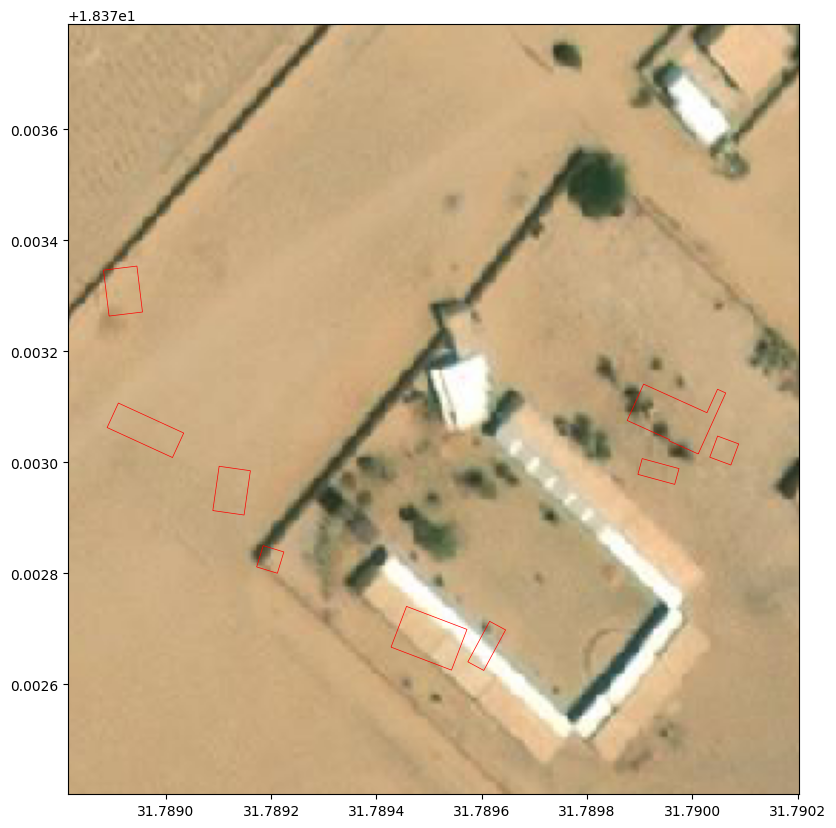

In [ ]:
plot_tiff_with_mask(img_tiff, buildings_gdf)

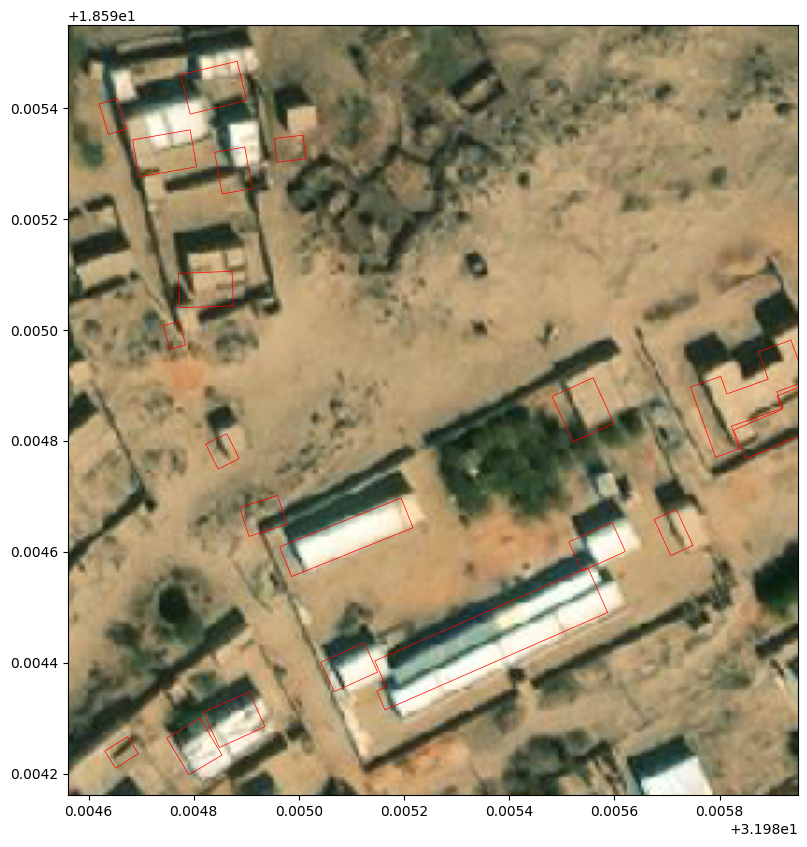

In [ ]:
plot_tiff_with_mask(img_tiff, buildings_gdf)

# Google Building Footprints

In [ ]:
footprints_db.columns

Index(['Location', 'QuadKey', 'Url', 'Size'], dtype='object')

In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/georefenrencing/score_thresholds_s2_level_4.csv')

In [ ]:
metadata.columns

Index(['s2_token', 'geometry', 'confidence_threshold_80%_precision',
       'confidence_threshold_85%_precision',
       'confidence_threshold_90%_precision', 'building_count_80%_precision',
       'building_count_85%_precision', 'building_count_90%_precision',
       'building_count', 'num_samples'],
      dtype='object')